# Get helper function for visualization

In [162]:
import requests
from pathlib import Path

# Download helper functions
if Path("helper_functions.py").is_file():
  print("Helper function already exists, skiping download")
else:
  print("Download helper functions")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Helper function already exists, skiping download


# Get data

In [163]:
import requests
from pathlib import Path

# Download helper functions
if Path("iris.data").is_file():
  print("Iris data already exists, skiping download")
else:
  print("Download Iris data")
  request = requests.get("https://raw.githubusercontent.com/DaryllLorenzo/IrisClassification/refs/heads/main/iris.data")
  with open("iris.data", "wb") as f:
    f.write(request.content)


Iris data already exists, skiping download


## Convert data to dataframe

In [164]:
import pandas as pd

# converting csv file to data frame
df = pd.read_csv("iris.data", sep=',',
                         names=['sepal length', 'sepal width', 'petal length', "petal width", "Class"])

df.loc[df['Class'] == 'Iris-setosa', 'Class'] = 0
df.loc[df['Class'] == 'Iris-versicolor', 'Class'] = 1
df.loc[df['Class'] == 'Iris-virginica', 'Class'] = 2
df

,sepal length,sepal width,petal length,petal width,Class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


##  Standardize the Data for using PCA (Principal Component Analysis) to help with visualization
PCA is effected by scale so it's needed to scale the features in data before applying PCA.

In [165]:
from sklearn.preprocessing import StandardScaler

# StandardScaler(mean = 0, variance = 1)

features = ['sepal length', 'sepal width', 'petal length', 'petal width']

# Separating out the features
X = df.loc[:, features].values

# Separating out the class
y = df.loc[:,['Class']].values

# Standardizing the features
X = StandardScaler().fit_transform(X)

### PCA projection in 2D

In [166]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents , columns = ['pca1', 'pca2'])

principalDf

,pca1,pca2
0,-2.264542,0.505704
1,-2.086426,-0.655405
2,-2.367950,-0.318477
3,-2.304197,-0.575368
4,-2.388777,0.674767
...,...,...
145,1.870522,0.382822
146,1.558492,-0.905314
147,1.520845,0.266795
148,1.376391,1.016362


Text(0.5, 1.0, 'Scatter Plot de PCA con Iris')

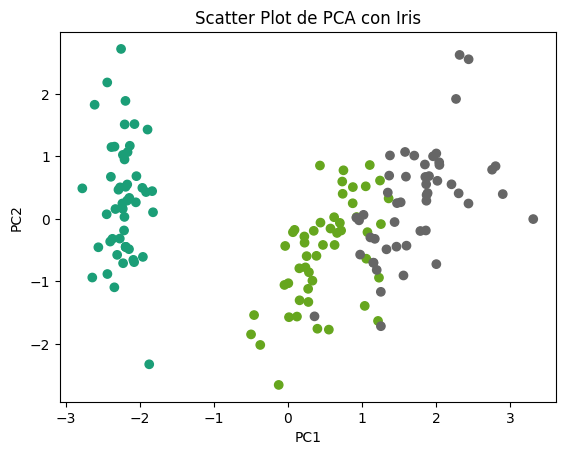

In [167]:
import matplotlib.pyplot as plt

plt.scatter(x = principalDf['pca1'],
            y = principalDf['pca2'],
            c = df['Class'],
            cmap = plt.cm.Dark2)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot de PCA con Iris')

### Pasar datos a tensors

In [168]:
import torch
from torch import nn
import numpy as np

# Datos sin escalar
# Transformar a tensores
principalComponents = torch.from_numpy(principalComponents).type(torch.float)
y = torch.from_numpy(y.astype(np.float64)).type(torch.LongTensor)

### Dividir datos

In [169]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(principalComponents,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

## Crear Modelo

In [170]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class IrisPC(nn.Module):
  """ Inicializar modelo de Clasificación para Iris

  Args:
    input_features (int) : Number of input features
    output_features (int) : Number of output features
    hidden_units (int) : Number of hidden units

  """
  def __init__(self, input_features: int, output_features: int, hidden_units: int = 8):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features,
                  out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,
                  out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,
                  out_features = output_features)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor :
    return self.layer_stack(x)

modelV1 = IrisPC(input_features = 2,
                 output_features = 3,
                 hidden_units = 128).to(device)

modelV1

IrisPC(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)

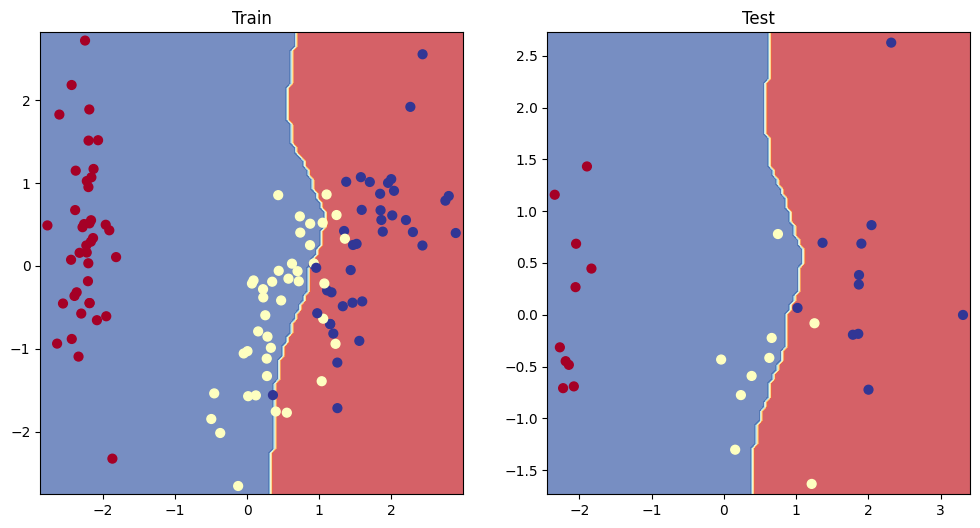

In [171]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(modelV1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(modelV1, X_test, y_test)

In [172]:
# Select loss fn and optimizer

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params = modelV1.parameters(),
    lr = 0.01
)

## Entrenar modelo

In [173]:
y_train[:5].squeeze()

tensor([0, 0, 1, 0, 0])

In [174]:
from sklearn.metrics import accuracy_score

# Pass data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 800

for epoch in range(epochs):
  modelV1.train()

  # Forward pass
  y_logits = modelV1(X_train)
  y_preds = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  # Calculate loss and acc
  loss = loss_fn(y_logits, y_train.squeeze())
  acc = accuracy_score(y_true = y_train,
                       y_pred = y_preds)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backprop
  loss.backward()

  # Gradient
  optimizer.step()

  ### Testing
  modelV1.eval()
  with torch.inference_mode():
    y_test_logits = modelV1(X_test)
    y_test_preds = torch.softmax(y_test_logits, dim = 1).argmax(dim = 1)

    test_loss = loss_fn(y_test_logits, y_test.squeeze())
    test_acc = accuracy_score(y_true = y_test,
                              y_pred = y_test_preds)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss: .4f} | Acc: {acc: .2f}% | Test_loss: {test_loss: .4f} | Test_acc: {test_acc: .2f}%")

Epoch: 0 | Loss:  1.1374 | Acc:  0.09% | Test_loss:  1.1249 | Test_acc:  0.07%
Epoch: 10 | Loss:  1.0063 | Acc:  0.55% | Test_loss:  0.9966 | Test_acc:  0.53%
Epoch: 20 | Loss:  0.9029 | Acc:  0.72% | Test_loss:  0.8918 | Test_acc:  0.77%
Epoch: 30 | Loss:  0.8167 | Acc:  0.77% | Test_loss:  0.8022 | Test_acc:  0.83%
Epoch: 40 | Loss:  0.7445 | Acc:  0.78% | Test_loss:  0.7257 | Test_acc:  0.83%
Epoch: 50 | Loss:  0.6847 | Acc:  0.78% | Test_loss:  0.6613 | Test_acc:  0.83%
Epoch: 60 | Loss:  0.6353 | Acc:  0.80% | Test_loss:  0.6079 | Test_acc:  0.87%
Epoch: 70 | Loss:  0.5945 | Acc:  0.82% | Test_loss:  0.5637 | Test_acc:  0.87%
Epoch: 80 | Loss:  0.5605 | Acc:  0.82% | Test_loss:  0.5269 | Test_acc:  0.87%
Epoch: 90 | Loss:  0.5320 | Acc:  0.82% | Test_loss:  0.4961 | Test_acc:  0.87%
Epoch: 100 | Loss:  0.5077 | Acc:  0.83% | Test_loss:  0.4699 | Test_acc:  0.87%
Epoch: 110 | Loss:  0.4868 | Acc:  0.83% | Test_loss:  0.4475 | Test_acc:  0.87%
Epoch: 120 | Loss:  0.4686 | Acc:  0.83

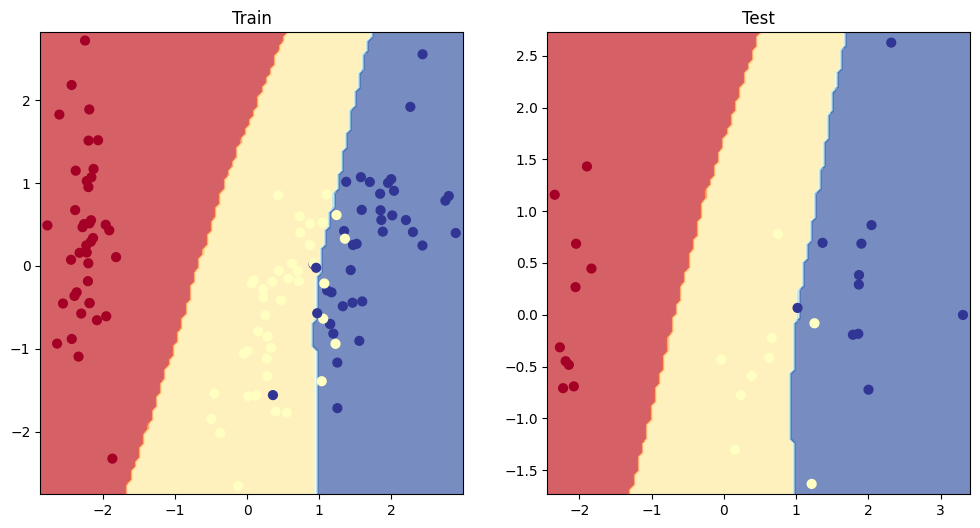

In [175]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(modelV1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(modelV1, X_test, y_test)